In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision import transforms
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split

# 1. Read training data

In [2]:
# Reading data
key_points_frame = pd.read_csv('data/training_frames_keypoints.csv')

key_points_frame.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


# 2. Display some information about the data

In [3]:
# Display one image statistics for better understanding
n = 0
image_name = key_points_frame.iloc[n,0]
key_points = (key_points_frame.iloc[n,1:]).to_numpy()
key_points = key_points.astype('float').reshape(-1,2)

print(f"Image name: {image_name}")
print(f"Landmarks shape: {key_points.shape}")
print(f"First 5 key points:\n{key_points[:5]}")

Image name: Luis_Fonsi_21.jpg
Landmarks shape: (68, 2)
First 5 key points:
[[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]
 [ 56. 125.]]


# 3. Look at images with keypoints

#### Below there is a function __show_keypoints__, that takes in an image and keypoints and displays them.

In [4]:
def show_keypoints(image, key_points):
    """Show images with keypoints"""
    plt.imshow(image)
    plt.scatter(key_points[:, 0], key_points[:, 1], s=20, c='b')

#### As these images are not all of the same size (and neither are the faces), we will need to standartize their shape to train a NN.

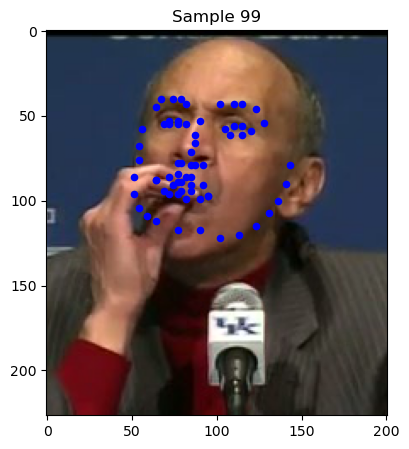

In [5]:
# Display different images by changing the index
index = 99

image_name = key_points_frame.iloc[index, 0]
key_points = key_points_frame.iloc[index, 1:].to_numpy()
key_points = key_points.astype('float').reshape(-1,2)

plt.figure(figsize=(5,5))
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_points)
plt.title(f'Sample {index}')
plt.show()

# 4. Custom Dataset Class

#### To prepare our data for training, we'll be using PyTorch's Dataset class.

#### We will override the following methods:

* __len__ so that len(dataset) returns the size of the dataset.
* __getitem__ to support the indexing such that dataset[i] can be used to get the i-th sample of image/keypoint data.

#### A sample of our dataset will be a dictionary {'image': image, 'keypoints': key_points}.

#### Our dataset will take an optional argument __transform__ so that any required processing can be applied on the sample.

In [6]:
class FaceKeypointsDataset(Dataset):
    """
    Marked face images Dataset Class.\n
    
    Args:
        csv_file (str): Path to the csv file.
        root_dir (str): Directory with all the images.
        transform (callable, optional): Optional transform to be apllied on a sample.
    """

    def __init__(self, csv_file, root_dir, transform=None):
        self.key_points_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.key_points_frame)
    
    def __getitem__(self, idx):
        # Image
        image_name = os.path.join(self.root_dir, self.key_points_frame.iloc[idx, 0])
        image = mpimg.imread(image_name)

        # Check whether the image is single-channel
        if image.ndim == 2:
            # Convert from single-channel to three-channel, repeating the channel in depth
            image = np.stack((image,)*3, axis=-1)
        # If image has an alpha color channel, get rid of it
        elif (image.shape[2] == 4):
            image = image[:, :, 0:3]
            
        # Keypoints
        key_points = self.key_points_frame.iloc[idx, 1:].to_numpy()
        key_points = key_points.astype('float').reshape(-1, 2)

        # Our sample
        sample = {'image': image, 'keypoints': key_points}

        # transforms
        if self.transform:
            sample = self.transform(sample)
     
        return sample

# Create an instance of the class

In [7]:
# instance of our custom dataset
face_dataset = FaceKeypointsDataset(csv_file='data/training_frames_keypoints.csv', root_dir='data/training/')

print(f"Length of the dataset: {len(face_dataset)}")

Length of the dataset: 3462


# Display some images and its shapes

0 (147, 143, 3) (68, 2)
1 (185, 180, 3) (68, 2)
2 (197, 192, 3) (68, 2)


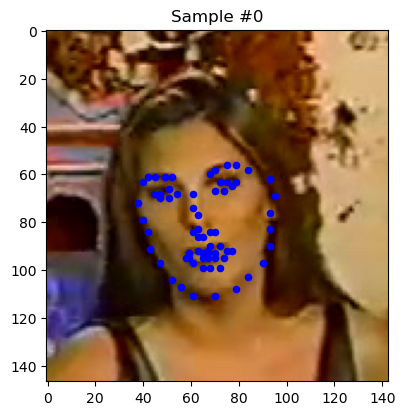

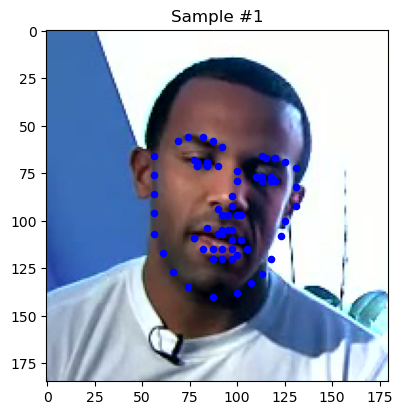

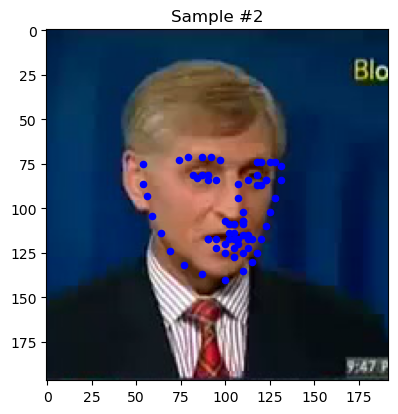

In [8]:
# Display a few images from the dataset
num_to_display = 3

for i in range(num_to_display):

    # define the size of images
    fig = plt.figure(figsize=(15,12))

    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i+1)
    ax.set_title(f"Sample #{i}")

    # using the same display function show_keypoints, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])

# 5. Transforms

#### The images above are not of the same size, and NN often expect images with fixed size and a normalized range for color ranges, and for Pytorch converted to Tensors.

#### Therefore, we will do some transforms:
* __Normalize__: to convert an image values with a range of [0,1].
* __Rescale__: to rescale an image to desired size.
* __ToTensor__: to convert numpy to torch

#### Also we will do some additional transforms for data augmentation:
* __RandomRotation__: to rotate the image randomly.
* __AddNoise__: to add random noise to the image.

#### We will use callable classes instead of functions to avoid passing parameters on each call. So, we need to implement the __call__ and __init__ (if we required parameters to be passed) methods.

In [9]:
class Normalize(object):
    """A class for normalizing the pixel values of an image within range [0, 1]."""

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        # scale color range from [0, 255] to [0, 1]
        image = image / 255.0
        # normalize keypoints to [0, 1] range
        # key_points = key_points / [image.shape[1], image.shape[0]]
        return {'image': image, 'keypoints': key_points}

class Rescale(object):
    """
    Rescale the image in a sample to a given size.\n

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is matched to output_size.
        If int, smaller of image edges is matched to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)

        image = cv2.resize(image, (new_w, new_h))
        key_points = key_points * [new_w / w, new_h / h]

        return {'image': image, 'keypoints': key_points}


# Random Rotation
class RandomRotation(object):
    """Randomly rotate the image."""

    def __init__(self, degrees=90):
        self.degrees = degrees

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']

        # Define the rotation
        angle = random.uniform(-self.degrees, self.degrees)
        rotation_mat = cv2.getRotationMatrix2D((image.shape[1]/2, image.shape[0]/2), angle, 1)

        # Rotate image
        rotated_image = cv2.warpAffine(image, rotation_mat, (image.shape[1], image.shape[0]))

        # Rotate keypoints
        ones = np.ones(shape=(len(key_points), 1))
        points_ones = np.hstack([key_points, ones])
        transformed_keypoints = rotation_mat.dot(points_ones.T).T

        return {'image': rotated_image, 'keypoints': transformed_keypoints}


# Add noise
class AddNoise(object):
    """Add random noise to the image."""

    def __init__(self, noise_level=0.1):
        self.noise_level = noise_level

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']

        # Generate random noise
        noise = np.random.normal(scale=self.noise_level, size=image.shape)

        # Add noise to the image
        noisy_image = image + noise

        # Clip pixel values to stay within [0, 255]
        noisy_image = np.clip(noisy_image, 0, 255)

        return {'image': noisy_image.astype(np.uint8), 'keypoints': key_points}


# ToTensors
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        if len(image.shape) == 2:
            image = image.reshape(image.shape[0], image.shape[1], 1)
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'keypoints': torch.from_numpy(key_points)}

# Create the tranformed base_dataset

In [10]:
# Define the data transform
base_transform = transforms.Compose([
    Rescale((224,224)),
    Normalize(),
    ToTensor()
])

# Create an instance of custom transformed base_dataset
base_dataset = FaceKeypointsDataset(csv_file='data/training_frames_keypoints.csv', root_dir='data/training/', transform=base_transform)

In [11]:
print('Length of dataset : ', len(base_dataset))

for i in range(5):
    sample = base_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Length of dataset :  3462
0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])
4 torch.Size([3, 224, 224]) torch.Size([68, 2])


In [12]:
test_dataset = FaceKeypointsDataset(csv_file='data/test_frames_keypoints.csv', root_dir='data/test/', transform=base_transform)

In [13]:
print('Length of dataset : ', len(test_dataset))

Length of dataset :  770


# 6. Add augmentations

In [14]:
# Define transformations for the train dataset
augmentation_transform = transforms.Compose([
    Rescale((224,224)),
    RandomRotation(90),
    AddNoise(noise_level=0.1),
    Normalize(),
    ToTensor()
])

# Create a new dataset with augmentations
augmented_dataset = FaceKeypointsDataset(csv_file='data/training_frames_keypoints.csv', root_dir='data/training/', transform=augmentation_transform)

# Merge a base dataset with an augmented dataset
merged_train_dataset = ConcatDataset([base_dataset, augmented_dataset])

In [15]:
print(f"Length of data with augmentations: {len(merged_train_dataset)}")

Length of data with augmentations: 6924


# 7. Batching and loading data

In [16]:
batch_size = 32

In [17]:
# Разделите данные на обучающую и валидационную выборки
train_idx, val_idx = train_test_split(np.arange(len(base_dataset)), test_size=0.2, random_state=42)

# Создайте Subset для обучающей и валидационной выборок
train_subset = Subset(base_dataset, train_idx)
val_subset = Subset(base_dataset, val_idx)

# Создайте DataLoader для обучающей и валидационной выборок
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

In [18]:
len(train_subset)

2769

In [19]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 8. CNN Architecture

In [20]:
class FaceKeyPoints(nn.Module):
    """
    CNN for predicting key points in face images.

    The network architecture consists of 5 convolutional layers (conv1-conv5) with the ReLu activation function
    and batch normalization, alternating with max pooling.
    The convolutional layers are followed by 3 fully connected layers (fc1-fc3) with ReLU activation function and dropout.

    Input data: face image size (batch_size, 3, height, width).
    Output data: predicted coordinates of 68 key points of the face size (batch_size, 136).
"""

    def __init__(self):
        super(FaceKeyPoints, self).__init__()

        # self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2) # 3 in_channels because of color image
        # batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, 3)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, 1) # leave the same size
        self.bn5 = nn.BatchNorm2d(512)
        
        # maxpool layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.fc1 = nn.Linear(in_features=512*6*6,
                             out_features=1024)
        
        self.fc2 = nn.Linear(in_features=1024,
                             out_features=512)
        
        self.fc3 = nn.Linear(in_features=512,
                             out_features=68*2)
        
        # dropout
        self.dropout = nn.Dropout(p=0.25)

    # forward pass
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        # Flatten for linear layer
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# 9. Parameters

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [43]:
# creating an instance of FaceKeyPoints
model = FaceKeyPoints().to(device)

## The training was on a cloud server with GPU, so let's upload an already trained and saved model.

In [1]:
# Uploading an already trained model
model = torch.load('CustomCNN.pth' map_location=torch.device('cpu'))
# eval mode
model.eval()

# print the structure of model
print(model)

In [44]:
n_epochs = 16
learning_rate = 0.0001

criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

In [74]:
class Normalize(object):
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        return {'image': image / 255.0, 'keypoints': key_points}

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))
        key_points = key_points * [new_w / w, new_h / h]
        return {'image': img, 'keypoints': key_points}

class RandomBrightnessContrast(object):
    """Randomly change the brightness and contrast of the image."""
    
    def __init__(self, brightness=0.2, contrast=0.2):
        self.brightness = brightness
        self.contrast = contrast
    
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        
        brightness_factor = 1.0 + random.uniform(-self.brightness, self.brightness)
        contrast_factor = 1.0 + random.uniform(-self.contrast, self.contrast)
        
        image = cv2.convertScaleAbs(image, alpha=contrast_factor, beta=brightness_factor * 50)
        
        return {'image': image, 'keypoints': key_points}
    
class RandomHorizontalFlip(object):
    """Randomly flip the image horizontally."""
    
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        
        if random.random() > 0.5:
            image = np.fliplr(image).copy()
            key_points[:, 0] = image.shape[1] - key_points[:, 0]
        
        return {'image': image, 'keypoints': key_points}

class RandomVerticalFlip(object):
    """Randomly flip the image vertically."""
    
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        
        if random.random() > 0.5:
            image = np.flipud(image).copy()
            key_points[:, 1] = image.shape[0] - key_points[:, 1]
        
        return {'image': image, 'keypoints': key_points}
class RandomCrop(object):
    """Randomly crop the image."""
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h, left: left + new_w]
        
        key_points = key_points - [left, top]
        
        return {'image': image, 'keypoints': key_points}
    
class ToTensor(object):
    def __call__(self, sample):
        image, key_points = sample['image'], sample['keypoints']
        if len(image.shape) == 2:
            image = image.reshape(image.shape[0], image.shape[1], 1)
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'keypoints': torch.from_numpy(key_points)}


class FaceKeypointsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.key_points_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.key_points_frame)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.key_points_frame.iloc[idx, 0])
        image = mpimg.imread(image_name)

        if image.ndim == 2:
            image = np.stack((image,) * 3, axis=-1)
        elif image.shape[2] == 4:
            image = image[:, :, :3]
            
        key_points = self.key_points_frame.iloc[idx, 1:].to_numpy()
        key_points = key_points.astype('float').reshape(-1, 2)

        sample = {'image': image, 'keypoints': key_points}

        if self.transform:
            sample = self.transform(sample)
     
        return sample


train_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomCrop((224, 224)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomRotation(degrees=30),
    AddNoise(noise_level=5),
    RandomBrightnessContrast(),
    Normalize(),
    ToTensor()
])

# Transforms for validation and test data (without augmentations)
test_transform = transforms.Compose([
    Rescale((224, 224)),
    Normalize(),
    ToTensor()
])

# Create the full dataset
full_dataset = FaceKeypointsDataset(csv_file='data/training_frames_keypoints.csv', root_dir='data/training/', transform=None)

# Split the dataset into training and validation sets
train_idx, val_idx = train_test_split(np.arange(len(full_dataset)), test_size=0.2, random_state=42)

# Create training and validation subsets
train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)

# Apply transforms to the training and validation subsets
train_subset.dataset.transform = train_transform
val_subset.dataset.transform = test_transform

# Create DataLoaders for training and validation
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Create the test dataset and DataLoader
test_dataset = FaceKeypointsDataset(csv_file='data/test_frames_keypoints.csv', root_dir='data/test/', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [75]:
len(val_loader)

22

# 10. Training

In [76]:
def train_net(model, criterion, optimizer, train_loader, val_loader, n_epochs, device):
    """
    Trains a CNN to recognize key points in images.\n

    Args:
        model (torch.nn.Module): The CNN model that needs to be trained.
        criterion (torch.nn.Module): A loss function used to evaluate the quality of model predictions.
        optimizer (torch.optim.Optimizer): The optimizer used to update the weights of the model.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        n_epochs (int): The number of epochs.
        device (torch.device): The device (CPU or GPU) on which the training will be performed.

    Returns:
        tuple: A tuple containing lists of loss function values for the training and validation sets at every epoch of learning.
    """

    pbar = tqdm(total=n_epochs * (len(train_loader) + len(val_loader)), desc='Training')
    train_losses = []
    val_losses = []

    # loop over the dataset multiple times
    for epoch in range(n_epochs):  
        # switch model to training mode
        model.train()

        running_train_loss = 0.0
        running_val_loss = 0.0

        # iterate through train loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their key_points
            images, key_points = data['image'], data['keypoints']
            # send them to device
            images, key_points = images.to(device), key_points.to(device)
            
            # flatten key_points
            key_points = key_points.view(key_points.size(0), -1)

            # convert variables to floats for regression loss
            key_points = key_points.float()
            images = images.float()

            # forward pass to get outputs
            outputs = model(images)

            # calculate the loss between predicted and target keypoints
            train_loss = criterion(outputs, key_points)

            # zero the gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            train_loss.backward()

            # update the weights
            optimizer.step()

            # add loss
            running_train_loss += train_loss.item()
            
            # print loss statistics
            pbar.update(1)
            pbar.set_description(f"Epoch {epoch}/{n_epochs}, Train Running Loss: {running_train_loss/(batch_i+1):.4f}")
            
        
        # average train loss per epoch
        avg_train_loss_per_epoch = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss_per_epoch)


        # switch model to evaluation mode
        model.eval()
        with torch.no_grad():
            for batch_i, data in enumerate(val_loader):
                # get the input images and their key_points
                _images, _key_points = data['image'], data['keypoints']
                # send them to device
                _images, _key_points = _images.to(device), _key_points.to(device)

                # flatten key_points
                _key_points = _key_points.view(_key_points.size(0), -1)

                # convert variables to floats for regression loss
                _key_points = _key_points.float()
                _images = _images.float()

                # get outputs
                _outputs = model(_images)

                # calculate the loss between predicted and target keypoints
                val_loss = criterion(_outputs, _key_points)

                running_val_loss += val_loss.item()

                pbar.update(1)
                pbar.set_description(f"Epoch {epoch}/{n_epochs}, Val Running Loss: {running_val_loss/(batch_i+1):.4f}")
                
            
            # average val loss per epoch
            avg_val_loss_per_epoch = running_val_loss / len(val_loader)
            val_losses.append(avg_val_loss_per_epoch)

        print(f"After Epoch {epoch+1}: Avg Train Loss: {avg_train_loss_per_epoch:.4f}, Avg Val Loss: {avg_val_loss_per_epoch:.4f}")


    pbar.close()
    print('Finished Training')
    
    return train_losses, val_losses

# Calling the training process using the function above

In [77]:
# call the train_net function for training
train_losses, val_losses = train_net(model, criterion, optimizer, train_loader, val_loader, n_epochs, device)

Epoch 0/16, Val Running Loss: 127.9980:   6%|▋         | 109/1744 [00:28<04:26,  6.13it/s] 

After Epoch 1: Avg Train Loss: 165.1650, Avg Val Loss: 127.9980


Epoch 1/16, Val Running Loss: 220.4896:  12%|█▎        | 218/1744 [00:56<04:08,  6.14it/s]  

After Epoch 2: Avg Train Loss: 151.1236, Avg Val Loss: 220.4896


Epoch 2/16, Val Running Loss: 103.1248:  19%|█▉        | 327/1744 [01:25<04:15,  5.54it/s]  

After Epoch 3: Avg Train Loss: 154.0318, Avg Val Loss: 103.1248


Epoch 3/16, Val Running Loss: 148.6772:  25%|██▌       | 436/1744 [01:54<03:33,  6.13it/s]  

After Epoch 4: Avg Train Loss: 137.9474, Avg Val Loss: 148.6772


Epoch 4/16, Val Running Loss: 143.3350:  31%|███▏      | 545/1744 [02:21<03:07,  6.38it/s]  

After Epoch 5: Avg Train Loss: 140.3197, Avg Val Loss: 143.3350


Epoch 5/16, Val Running Loss: 84.6812:  38%|███▊      | 654/1744 [02:48<02:58,  6.09it/s]   

After Epoch 6: Avg Train Loss: 132.4663, Avg Val Loss: 84.6812


Epoch 6/16, Val Running Loss: 109.6734:  44%|████▍     | 763/1744 [03:16<02:40,  6.10it/s]  

After Epoch 7: Avg Train Loss: 126.0040, Avg Val Loss: 109.6734


Epoch 7/16, Val Running Loss: 101.1908:  50%|█████     | 872/1744 [03:44<02:30,  5.80it/s]  

After Epoch 8: Avg Train Loss: 129.9587, Avg Val Loss: 101.1908


Epoch 8/16, Val Running Loss: 191.1039:  56%|█████▋    | 981/1744 [04:14<02:08,  5.93it/s]  

After Epoch 9: Avg Train Loss: 118.0264, Avg Val Loss: 191.1039


Epoch 9/16, Val Running Loss: 161.6537:  62%|██████▎   | 1090/1744 [04:43<01:49,  5.98it/s]  

After Epoch 10: Avg Train Loss: 123.5161, Avg Val Loss: 161.6537


Epoch 10/16, Val Running Loss: 148.2726:  69%|██████▉   | 1199/1744 [05:11<01:29,  6.10it/s]  

After Epoch 11: Avg Train Loss: 115.6088, Avg Val Loss: 148.2726


Epoch 11/16, Val Running Loss: 75.9978:  75%|███████▌  | 1308/1744 [05:40<01:19,  5.51it/s]   

After Epoch 12: Avg Train Loss: 114.7944, Avg Val Loss: 75.9978


Epoch 12/16, Val Running Loss: 108.2603:  81%|████████▏ | 1417/1744 [06:10<00:57,  5.70it/s]  

After Epoch 13: Avg Train Loss: 108.8084, Avg Val Loss: 108.2603


Epoch 13/16, Val Running Loss: 89.4603:  88%|████████▊ | 1526/1744 [06:39<00:39,  5.57it/s]   

After Epoch 14: Avg Train Loss: 115.3585, Avg Val Loss: 89.4603


Epoch 14/16, Val Running Loss: 72.6179:  94%|█████████▍| 1635/1744 [07:08<00:20,  5.32it/s]   

After Epoch 15: Avg Train Loss: 112.1969, Avg Val Loss: 72.6179


Epoch 15/16, Val Running Loss: 96.2382: 100%|██████████| 1744/1744 [07:39<00:00,  3.79it/s]   

After Epoch 16: Avg Train Loss: 108.1514, Avg Val Loss: 96.2382
Finished Training


# Visualization of training process

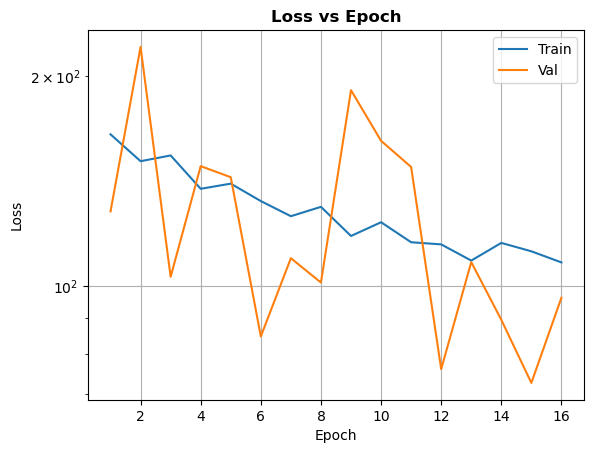

In [78]:
# Visualize the train and val losses
plt.figure()
plt.semilogy(range(1, n_epochs+1),train_losses, label='Train')
plt.semilogy(range(1, n_epochs+1),val_losses, label='Val')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch', fontweight='bold')
plt.legend()
plt.show()

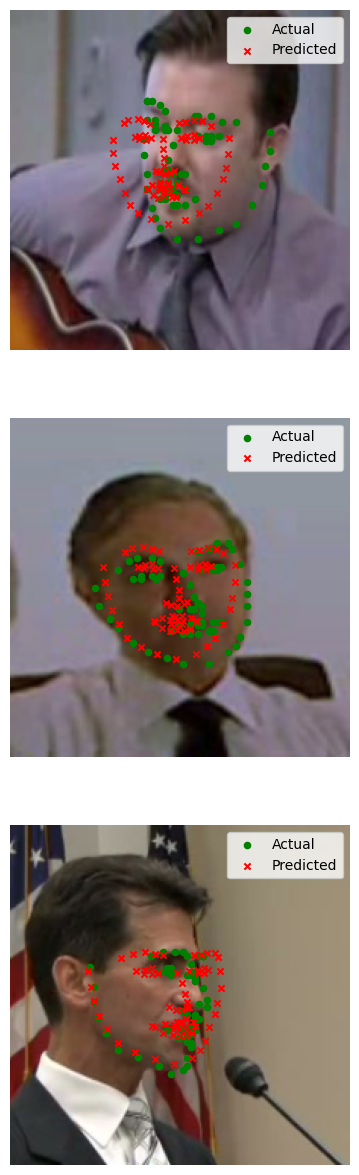

In [82]:
def show_keypoints(ax, image, predicted_keypoints=None, actual_keypoints=None):
    height, width = image.shape[:2]
    ax.imshow(image)
    if actual_keypoints is not None:
        ax.scatter(actual_keypoints[:, 0], actual_keypoints[:, 1], s=20, marker='o', c='g', label='Actual')
    if predicted_keypoints is not None:
        ax.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], s=20, marker='x', c='r', label='Predicted')
    ax.legend()
    ax.axis('off')

def visualize_predictions(dataset, model, device, num_images=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    _, axs = plt.subplots(nrows=num_images, ncols=1, figsize=(15, 15))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            sample = dataset[idx]
            image = sample['image'].unsqueeze(0)
            image = image.to(device)
            image = image.float()
            predicted_keypoints = model(image).view(-1, 68, 2).cpu().numpy().squeeze()
            actual_keypoints = sample['keypoints'].numpy()
            denormalized_image = image.squeeze().cpu().numpy().transpose(1, 2, 0) * 255.0
            show_keypoints(axs[i], denormalized_image, predicted_keypoints, actual_keypoints)

    plt.show()

# call the above visualization function
visualize_predictions(test_dataset, model, device, num_images=3)

# 11. Evaluate model on test data from __train folder__

In [83]:
def evaluate_model(model, test_loader, criterion):
    """
    Evaluates the quality of the trained model on a test subset.\n

    Args:
        model (torch.nn.Module): A trained model whose quality needs to be evaluated.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (torch.nn.Module): A loss function used to evaluate the quality of model predictions.

    Returns:
        float: The average value of the loss function on the test dataset.
    """

    # switch model to evaluation mode
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, key_points = data['image'], data['keypoints']
            images, key_points = images.to(device), key_points.to(device)
            
            # flatten key_points
            key_points = key_points.view(key_points.size(0), -1)
            
            # convert variables to floats for regression loss
            key_points = key_points.float()
            images = images.float()

            # get outputs
            output_pts = model(images)
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_points)
            # add loss
            total_loss += loss.item()

    # average loss
    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")
    
    return avg_loss

# Call the function evaluate_model after training
test_loss = evaluate_model(model, test_loader, criterion)

Test Loss: 85.7069


# 12. Visualize some predictions

In [84]:
def show_keypoints(ax, image, keypoints, predicted_keypoints=None):
    """Show image with keypoints"""
    # height, width = image.shape[:2]
    # keypoints = keypoints * [width, height]
    ax.imshow(image)
    ax.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='b', label='Actual')
    if predicted_keypoints is not None:
        # predicted_keypoints = predicted_keypoints * [width, height]
        ax.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], s=20, marker='x', c='r', label='Predicted')
    ax.legend()
    ax.axis('off')

In [85]:
def visualize_predictions(model, test_loader, num_images=9):
    model.eval()
    images_shown = 0
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Real and Predicted Key Points')

    with torch.no_grad():
        for data in test_loader:
            images, key_points = data['image'], data['keypoints']
            images, key_points = images.to(device), key_points.to(device)

            key_points = key_points.view(key_points.size(0), -1)
            key_points = key_points.float()
            images = images.float()

            output_pts = model(images)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    plt.show()
                    return
                
                predicted_keypoints = output_pts[i].cpu().view(-1, 2).numpy()
                real_keypoints = key_points[i].cpu().view(-1, 2).numpy()

                image = images[i].cpu().numpy().transpose((1, 2, 0))
                image = image * 255.0

                ax = axes[images_shown % 3]
                ax.clear()
                show_keypoints(ax, image, real_keypoints, predicted_keypoints)
                ax.set_title(f'Image {images_shown+1}')
                
                images_shown += 1
                
                if images_shown % 3 == 0 and images_shown < num_images:
                    plt.show()
                    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                    fig.suptitle('Real and Predicted Key Points')
                    
    plt.show()

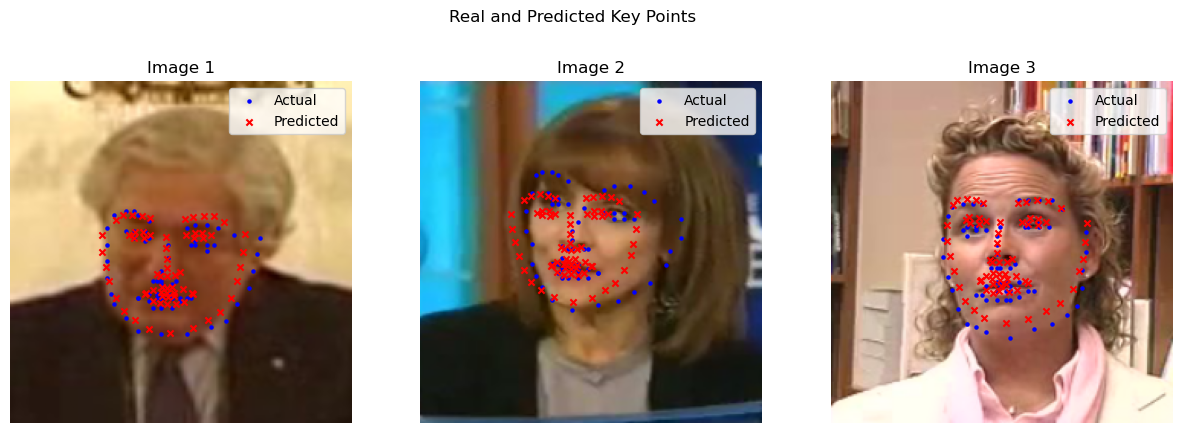

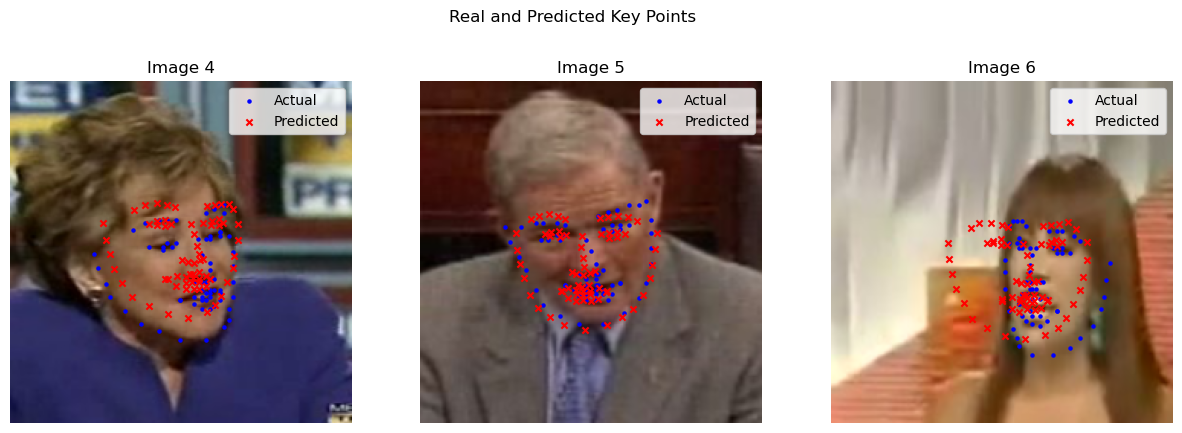

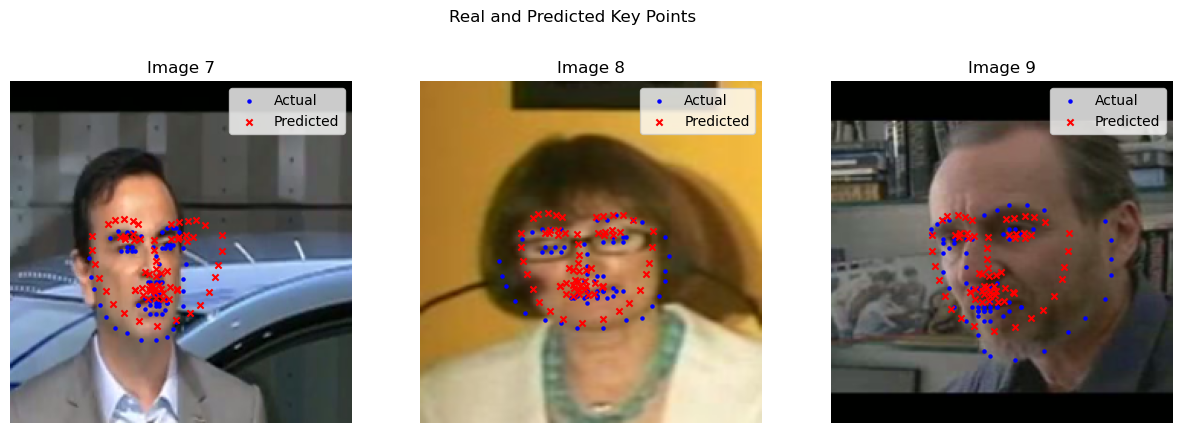

In [87]:
# Call the function visualize_predictions after evaluating the model
visualize_predictions(model, test_loader, num_images=9)

# 13. Save model

In [53]:
torch.save(model.state_dict(), 'customCNN.pth')